# Using a random forest to estimate ozone air quality class given meteorological data
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_ml_ats/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_ml_ats/blob/main/code/ann_ozone_joshuatree.ipynb)

* Example by Daniel Hueholt and Zaibeth Carlo Frontera at Colorado State University (CSU) for Program for Climate Model Diagnosis and Intercomparison at Lawrence Livermore National Lab Machine Learning tutorial
* Data processed and Colab notebook created by TA Jamin Rader [CSU] for ATS 780A7 Spring 2022 at CSU led by Prof. Elizabeth Barnes
* Random forest code adapted from iris dataset example by Prof. Elizabeth Barnes, Aaron Hill and Wei-Ting Hsiao based on Avinash Navlani's Datacamp tutorial code

# 0. Set Up Environments

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = True


In [ ]:
import sys
import numpy as np
import seaborn as sb

import pandas as pd
import datetime
import tensorflow as tf
#import tensorflow.keras as keras
import sklearn
#import pydot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# %matplotlib inline

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")  

python version = 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy version = 1.21.6
tensorflow version = 2.8.0


In [ ]:
if(IN_COLAB==True):
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        local_path = '/content/drive/My Drive/Colab Notebooks/'
    except:
        local_path = './'
else:
    local_path = '../figures/'

Mounted at /content/drive


# 1. Data Preparation

### 1.1 Data Overview

This is ozone and meteorological data from [CASTNET](https://www.epa.gov/castnet) (Clean Air Status and Trends Network) for Joshua Tree National Park, located just outside of Palm Springs and about 100 miles east of Los Angeles. The National Park Service monitors ozone in their parks. Joshua Tree has recorded at least 30 exceedance days per year [since 2016](https://www.nps.gov/subjects/air/ozone-exceed.htm). An exceedance day occurs when the daily maximum 8-hour ozone average is 71 ppb or higher. For comparison, Rocky Mountain NP has only experienced 35 ozone exceedance days since 2016.





In [ ]:
# Read in data from url
url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/ozone_data_joshuatreenp.csv"
data = pd.read_csv(url,parse_dates=["DATE_TIME"],infer_datetime_format=True)

# Fix data issue with Daylight Savings Time
duplicate_dates = data['DATE_TIME'][data.duplicated('DATE_TIME')]
for dup_date in duplicate_dates:
  idx = data['DATE_TIME'].eq(dup_date).idxmax()
  data.at[idx, 'DATE_TIME'] = dup_date - pd.Timedelta(value=1, unit='hours')  

# Add hour and day of year
data['HOUR'] = data['DATE_TIME'].dt.hour
data['MONTH'] = data['DATE_TIME'].dt.month
data['YEAR'] = data['DATE_TIME'].dt.year
data['DAYOFYEAR'] = data['DATE_TIME'].dt.dayofyear
data.sort_values('DATE_TIME', inplace=True, ignore_index = True)

Let's take a look at the data. We have data for ozone, temperature, relative humidity, and wind direction, among others.

In [ ]:
display(data.head())

,SITE_ID,DATE_TIME,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,WINDSPEED_SCALAR,UPDATE_DATE,HOUR,MONTH,YEAR,DAYOFYEAR
0,JOT403,2010-01-01 00:00:00,3.4000,2.4000,29.0,0.0,46.0,0.0,3.8000,189.0,2.0,3.05,3.8000,10/30/14 10:27,0,1,2010,1
1,JOT403,2010-01-01 01:00:00,3.4000,2.5999,29.0,0.0,46.0,0.0,3.2000,189.0,5.0,3.05,3.2000,10/30/14 10:27,1,1,2010,1
2,JOT403,2010-01-01 02:00:00,3.5999,2.7000,26.0,0.0,46.0,0.0,3.5000,191.0,4.0,3.05,3.5000,10/30/14 10:27,2,1,2010,1
3,JOT403,2010-01-01 03:00:00,3.3000,2.8000,28.0,0.0,46.0,0.0,3.0999,190.0,5.0,3.05,3.0999,10/30/14 10:27,3,1,2010,1
4,JOT403,2010-01-01 04:00:00,3.2000,2.5999,32.0,0.0,45.0,0.0,3.5999,191.0,4.0,3.05,3.5999,10/30/14 10:27,4,1,2010,1


### 1.2 Define Input and Output

The 2015 benchmark for [human health ozone condition](https://www.nps.gov/articles/analysis-methods2020.htm) is shown here. Let us predict whether the ozone quality will be classified as good, fair, or poor over 8-hour periods.

**Good**   $\leq$ 54.9 ppb

**Fair**   55.0 - 70.9 ppb

**Poor**   $\geq$ 71.0 ppb

Let's start out by training our model using Temperature, Relative Humidity, Windspeed, and Day of Year.

In [ ]:
# Here are all the different variables that we could use for training our neural
# nework (except ozone, of course)
data.columns

Index(['SITE_ID', 'DATE_TIME', 'TEMPERATURE', 'TEMPERATURE_DELTA',
       'RELATIVE_HUMIDITY', 'SOLAR_RADIATION', 'OZONE', 'PRECIPITATION',
       'WINDSPEED', 'WIND_DIRECTION', 'SIGMA_THETA', 'FLOW_RATE',
       'WINDSPEED_SCALAR', 'UPDATE_DATE', 'HOUR', 'MONTH', 'YEAR',
       'DAYOFYEAR'],
      dtype='object')

**EDIT the Input Variables Here:** Reminder, if you choose to use wind direction, you must first convert it to a vector for averaging.

In [ ]:
# List of strings from the available column names in the data set
INPUT_VARIABLES = ['TEMPERATURE', 'RELATIVE_HUMIDITY', 
                   'WINDSPEED', 'DAYOFYEAR',]

In [ ]:
# Let's isolate our variables of interest and take the 8-hour running mean

# First using input and output variables together to take running mean
df_data_to_be_used = data[['OZONE'] + INPUT_VARIABLES] 

# Here we take the 8-hour rolling mean (note: DATE_TIME does not work)
df_data_to_be_used = df_data_to_be_used.rolling(8).mean()

# Now adding Date and Time components
df_data_to_be_used[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']] = \
    data[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']] 

# Dropping NaNs
df_data_to_be_used.dropna(inplace=True)

display(df_data_to_be_used.head())

,OZONE,TEMPERATURE,RELATIVE_HUMIDITY,WINDSPEED,DAYOFYEAR,DATE_TIME,HOUR,MONTH,YEAR
7,45.125,3.299987,30.875,3.337462,1.0,2010-01-01 07:00:00,7,1,2010
8,45.125,3.749988,30.875,2.899962,1.0,2010-01-01 08:00:00,8,1,2010
9,45.375,4.374975,30.500,2.649962,1.0,2010-01-01 09:00:00,9,1,2010
10,45.625,5.074975,30.375,2.387462,1.0,2010-01-01 10:00:00,10,1,2010
11,46.000,5.862475,29.875,2.249975,1.0,2010-01-01 11:00:00,11,1,2010


In [ ]:
# Creating a numpy array for our inputs and outputs
input = df_data_to_be_used[INPUT_VARIABLES].values
output_raw = df_data_to_be_used['OZONE'].values

# Creating numpy arrays for time/date info for visualizations
hour = df_data_to_be_used['HOUR'].values
month = df_data_to_be_used['MONTH'].values
year = df_data_to_be_used['YEAR'].values

# Turning ozone into classification problem:
  # Class 0: Good, Class 1: Fair, Class 2: Poor
output_class = (output_raw >= 55).astype(int) + (output_raw >= 71).astype(int)
output = (output_class.reshape(-1,1) == np.unique(output_class)).astype(int)

# Here is how our data is encoded into classes.
print('Ozone Value:', output_raw[0])
print('Ozone Class:', output_class[0])
print('Encoded As:', output[0])
print()
print('Ozone Value:', output_raw[2000])
print('Ozone Class:', output_class[2000])
print('Encoded As:', output[2000])

Ozone Value: 45.125
Ozone Class: 0
Encoded As: [1 0 0]

Ozone Value: 58.0
Ozone Class: 1
Encoded As: [0 1 0]


In [ ]:
# Printing the shapes of our input and output arrays (#samples , #dimension of input/output)
print('Input Array Shape:', input.shape)
print('Output Array Shape:', output.shape)

Input Array Shape: (92409, 4)
Output Array Shape: (92409, 3)


### 1.3 Visualizing our Data

Let's look at what our output data actually looks like.

In [ ]:
# How often does our data fall into each category?
calcpercent = lambda cat: str((np.sum(output_class == cat)/len(output_class)*100).astype(int))

# Print out the sizes of each class
print('Frequency for each Ozone Category')
print('Good: ' + calcpercent(0) + '%')
print('Fair: ' + calcpercent(1) + '%')
print('Poor: ' + calcpercent(2) + '%')

# Plot label distributions
# fig,ax = plt.subplots()
# label_names = ['Good', 'Fair', 'Poor']
# labels, counts = np.unique(output_class, return_counts=True)
# plt.bar(labels, (counts/np.sum(counts)*100), align='center', width=0.4, color='#8F00FF')
# plt.gca().set_xticks(labels)
# plt.xlim(-1,len(label_names))
# ax.set_xticklabels(label_names)
# plt.title('Sample percentage by label')
# plt.ylabel('Sample percentage')
# plt.yticks([0, 20, 40, 60])
# plt.savefig(local_path + '/' + 'classes'+'.png', dpi_val=400)


Frequency for each Ozone Category
Good: 65%
Fair: 28%
Poor: 6%


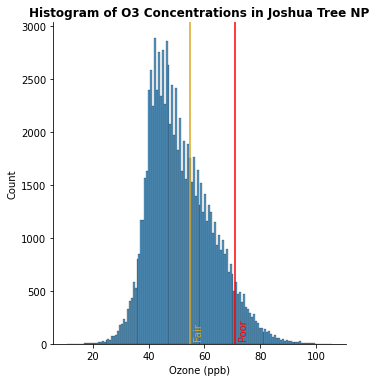

In [ ]:
# Distribution of ozone concentrations
sb.displot(output_raw, kind='hist')
plt.xlabel('Ozone (ppb)')
plt.axvline(x=71, color='red')
plt.axvline(x=55, color='goldenrod')
plt.text(56, 50, 'Fair', rotation=90, color='goldenrod')
plt.text(72, 50, 'Poor', rotation=90, color='red')

plt.title('Histogram of O3 Concentrations in Joshua Tree NP', fontweight='demi')
plt.plot()
plt.show()

O3 Concentrations in Each Month


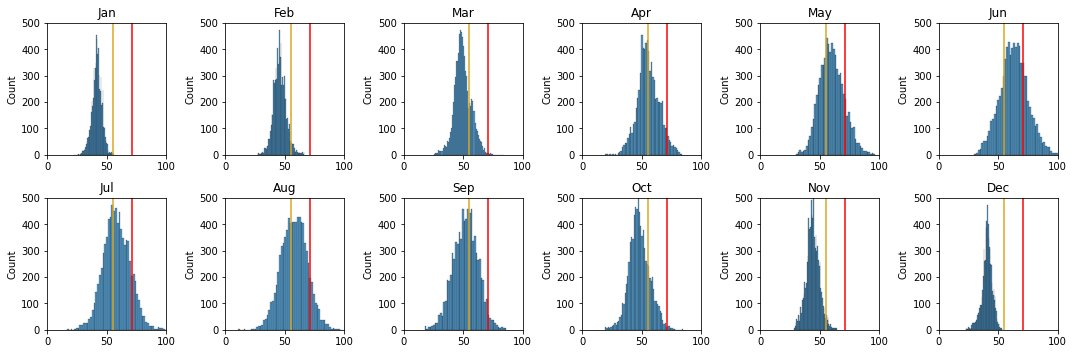

In [ ]:
# Distribution of ozone concentrations in each month

fig, axs = plt.subplots(2, 6, figsize = (15,5))

for m in np.arange(12):
  ax = axs[m//6,m%6]
  sb.histplot(output_raw[month == m+1], ax=ax)
  ax.set_title(datetime.datetime.strptime(str(m+1), "%m").strftime("%b"))
  ax.axvline(x=71, color='red')
  ax.axvline(x=55, color='goldenrod')
  ax.set_xlim(0,100)
  ax.set_ylim(0,500)

fig.tight_layout(pad=1.0)
print('O3 Concentrations in Each Month')

O3 Concentrations in Each Year


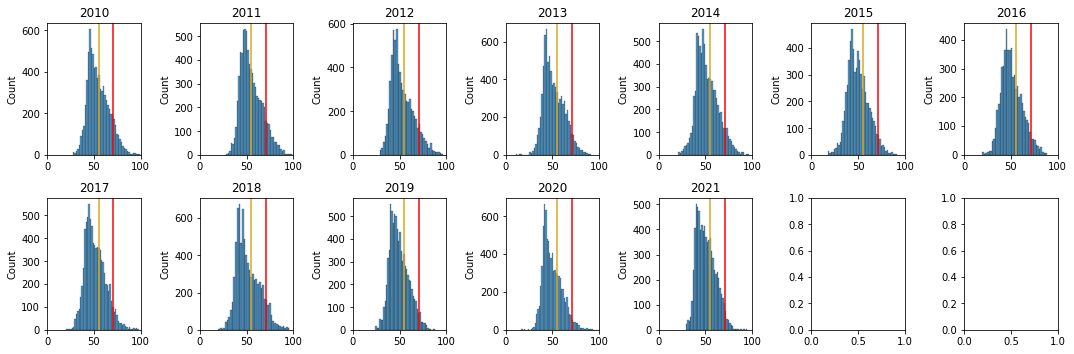

In [ ]:
# Distribution of ozone concentrations in each year

fig, axs = plt.subplots(2, 7, figsize = (15,5))

axidx = 0
for y in np.unique(year):
  ax = axs[axidx//7,axidx%7]
  sb.histplot(output_raw[year == y], ax=ax)
  ax.set_title(y)
  ax.axvline(x=71, color='red')
  ax.axvline(x=55, color='goldenrod')
  ax.set_xlim(0,100)
  axidx+=1

fig.tight_layout(pad=1.0)
print('O3 Concentrations in Each Year')

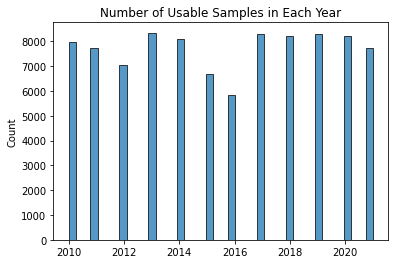

In [ ]:
# How many samples are available in each year? Data cannot be used if 
# there are NaNs (see 2013)
sb.histplot(year)
plt.title('Number of Usable Samples in Each Year');

### 1.4 Partitioning Data in Training, Validation, and Testing Sets

Our data is highly autocorrelated, so we are going to separate training, validation, and testing by grabbing different years of data. *Not* by random sampling.

**Some Variable Definitions**

* ```Xtrain/Xval/Xtest:*** 2-D Arrays of input data (shape: #samples, #input_variables)```

* ```Ttrain/Tval/Ttest:*** 2-D Arrays of target output data (true ozone class likelihood; shape: #samples, #classes)```

* ```Ptrain/Pval/Ptest:*** 2-D Arrays of predicted output data (predicted ozone class likelihoods; shape: #samples, #classes)```

* ```Xtrain_raw/Xval_raw/Xtest_raw:*** 2-D Arrays of raw (pre-standardized) input data (shape: #samples, #input_variables)```

* ```O3train/O3val/O3test:*** 1-D Arrays of raw ozone measurements (ppb; shape: #samples)```

* ```Cttrain/Ctval/Cttest:*** 1-D Arrays of the true ozone class (shape: #samples)```

* ```Cptrain/Cpval/Cptest:*** 1-D Arrays of the predicted ozone class with the highest likelihood (shape #samples)```

**EDIT the years used for training, validation and testing here:**

In [ ]:
# Default: Use the years 2010-2017 for training, 2018-2019 for validation, and 2020-2021 for testing
TRAIN_RANGE = (2010, 2017)
VAL_RANGE = (2018, 2019)
TEST_RANGE = (2020, 2021)

In [ ]:
# Splitting into training, testing, validation

# This function returns a boolean array of years that fall within the given year range
year_bool = lambda yrrange: np.logical_and(year>=yrrange[0], year<=yrrange[1])

# Create the input and output arrays from training, testing, validation sets
# Inputs haven't been standardized yet (thus "_raw")

Xtrain_raw = input[year_bool(TRAIN_RANGE)] # these are the inputs (X)
Ttrain = output[year_bool(TRAIN_RANGE)] # these are the outputs (T is for target)

Xval_raw = input[year_bool(VAL_RANGE)]
Tval = output[year_bool(VAL_RANGE)]

Xtest_raw = input[year_bool(TEST_RANGE)]
Ttest = output[year_bool(TEST_RANGE)]

# These are the raw outputs in each set for use later
O3train = output_raw[year_bool(TRAIN_RANGE)]
O3val = output_raw[year_bool(VAL_RANGE)]
O3test = output_raw[year_bool(TEST_RANGE)]

print('Shapes:')
print('  Xtrain: ', Xtrain_raw.shape)
print('  Xval: ', Xval_raw.shape)
print('  Xtest: ', Xtest_raw.shape)
print('  Ttrain: ', Ttrain.shape)
print('  Tval: ', Tval.shape)
print('  Ttest: ', Ttest.shape)

Shapes:
  Xtrain:  (59957, 4)
  Xval:  (16512, 4)
  Xtest:  (15940, 4)
  Ttrain:  (59957, 3)
  Tval:  (16512, 3)
  Ttest:  (15940, 3)


In [ ]:
# Standardizing the training, testing, and validation data

# This function takes a raw set of input fields (for example, the training, 
# validation, or testing arrays), and standardizes it based on the training data.

standardize_input = lambda dat, x, s: (dat - x)/s 

# Calculate mean and standard deviation of the training data
trainmean = Xtrain_raw.mean(axis=0) 
trainstd  = Xtrain_raw.std(axis=0) 

Xtrain = standardize_input(Xtrain_raw, trainmean, trainstd)
Xval = standardize_input(Xval_raw, trainmean, trainstd)
Xtest = standardize_input(Xtest_raw, trainmean, trainstd)

# 2. Random Forest

### 2.1 Building the Model

In [ ]:
# Let's import some different things we will use to grow the random forest and 
# evaluate or visualize its performance.
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
### Here is where we actually build the model

# Create and Train the Random Forest Classifier
#-------------------------------------------------------------------------------------------------
# MODIFY: important tunable parameters (hyperparameters) for model
number_of_trees = 30               # number of trees to "average" together to create a random forest
tree_depth = 3                     # maximum depth allowed for each tree
node_split = 2                     # minimum number of training samples needed to split a node
leaf_samples = 1                   # minimum number of training samples required to make a leaf node
criterion = 'gini'                 # 'gini' or 'entropy'
bootstrap = False                  # whether to perform "bagging=bootstrap aggregating" or not
max_samples = None                 # number of samples to grab when training each tree IF bootstrap=True, otherwise None
class_weight = None                # class weights, default None. Use 'balanced' to weight by class frequency, customize with format [{0:1.0,1:1.0}, {0:1.0,1:1.0}, {0:1.0,1:1.0}]
RAND_STATE = 13                    # specify random state for reproducibility
#-------------------------------------------------------------------------------------------------

rf=RandomForestClassifier(n_estimators=number_of_trees,
                           criterion=criterion,     
                           random_state=RAND_STATE,
                           min_samples_split = node_split,
                           min_samples_leaf = leaf_samples,
                           max_depth = tree_depth,
                           bootstrap = bootstrap,
                           class_weight = class_weight,
                           max_samples = max_samples,
                          )



### 2.2 Training the Model

In [37]:
# Train the model using the training sets
rf.fit(Xtrain,Ttrain)

RandomForestClassifier(bootstrap=False, max_depth=3, n_estimators=30,
                       random_state=13)

Now we can make predictions on the training and validation datasets.

In [39]:
Ptrain=rf.predict(Xtrain) # make predictions on the training dataset
Pval=rf.predict(Xval) # make predictions on the validation set

# Useful for evaluating performance later
Cptrain = Ptrain.argmax(axis=1) # 1-D array of predicted class (highest likelihood)
Cpval = Pval.argmax(axis=1)
Cttrain = Ttrain.argmax(axis=1) # 1-D array of truth class
Ctval = Tval.argmax(axis=1)

### 2.3 Model Performance


Now we will evaluate the random forest's performance in more depth. Categorical accuracy describes how often any class was correctly predicted. However, categorical accuracy can be deceptive in problems with unbalanced classes! Since 65% of our data are from days with "Good" ozone, our model could predict "Good" every time and we would still be 65% accurate. This doesn't allow us to learn anything about what it takes to predict "Fair" or "Poor" ozone days. Below, we compare categorical accuracy to weighted categorical accuracy, which takes into account class imbalances.

In [40]:
from sklearn.metrics import f1_score, accuracy_score
print('Validation Categorical Accuracy:', accuracy_score(Ctval, Cpval) )

# Weight equal to the inverse of the frequency of the class
cat_weights = np.sum((1 / np.mean(Ttrain, axis=0)) * Tval, axis=1) 
print('Validation Weighted Categorical Accuracy:', accuracy_score(Ctval, Cpval, sample_weight=cat_weights) )

Validation Categorical Accuracy: 0.7613250968992248
Validation Weighted Categorical Accuracy: 0.5365173879378982


A useful way to visualize a model's performance on a classification problem is through a *confusion matrix*. This displays the frequency of the predicted class agains the frequency of the true (target) class. A confusion matrix makes it simple to see whether a certain class is being underpredicted or overpredicted in favor of another. In a perfect confusion matrix, the diagonal entries will be one, with all other entries zero (i.e. it will be the identity matrix).

In [41]:
def confusion_matrix(predclasses, targclasses):

  class_names = np.unique(targclasses)

  table = []
  for pred_class in class_names:
    row = []
    for true_class in class_names:
        row.append(100 * np.mean(predclasses[targclasses == true_class] == pred_class))
    table.append(row)
  class_titles_t = ["T(Good)", "T(Fair)", "T(Poor)"]
  class_titles_p = ["P(Good)", "P(Fair)", "P(Poor)"]
  conf_matrix = pd.DataFrame(table, index=class_titles_p, columns=class_titles_t)
  display(conf_matrix.style.background_gradient(cmap='Greens').format("{:.1f}"))

In [42]:
print("Predicted versus Target Classes")
confusion_matrix(Cptrain, Cttrain)
confusion_matrix(Cpval, Ctval)

Predicted versus Target Classes


,T(Good),T(Fair),T(Poor)
P(Good),91.2,47.1,16.0
P(Fair),8.8,52.9,84.0
P(Poor),0.0,0.0,0.0


,T(Good),T(Fair),T(Poor)
P(Good),90.4,44.9,14.0
P(Fair),9.6,55.1,86.0
P(Poor),0.0,0.0,0.0


Violin plots of the class frequencies can tell us whether the distribution of the predicted classes match the actual values.

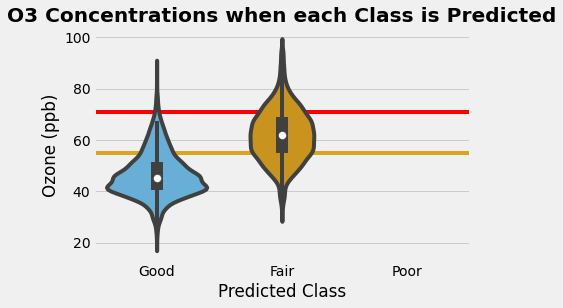

In [43]:
df_class0 = pd.DataFrame(O3val[Cpval == 0])
df_class1 = pd.DataFrame(O3val[Cpval == 1])
df_class2 = pd.DataFrame(O3val[Cpval == 2])

oi_pal = {0: '#56B4E9', 1: '#E69F00', 2: '#D55E00'}
sb.violinplot(data = [O3val[Cpval == 0], 
                     O3val[Cpval == 1], 
                     O3val[Cpval == 2]], palette=oi_pal)

plt.axhline(55, color='goldenrod', zorder=0)
plt.axhline(71, color='red', zorder=0)
plt.ylabel('Ozone (ppb)')
plt.xlabel('Predicted Class')
plt.xticks([0,1,2], ["Good", "Fair", "Poor"],)
plt.title('O3 Concentrations when each Class is Predicted', fontweight='demi')
plt.show()

# 3. Explaining the model's predictions
We have determined whether the random forest's output is accurate. We can now turn to exploring how these predictions came about!

### 3.1 Visualize an individual tree
Decision trees are *interpretable*, i.e. their decisions can be directly understood. Looking at individual trees can help us to get a sense of whether the forest model is making physically reasonable predictions.

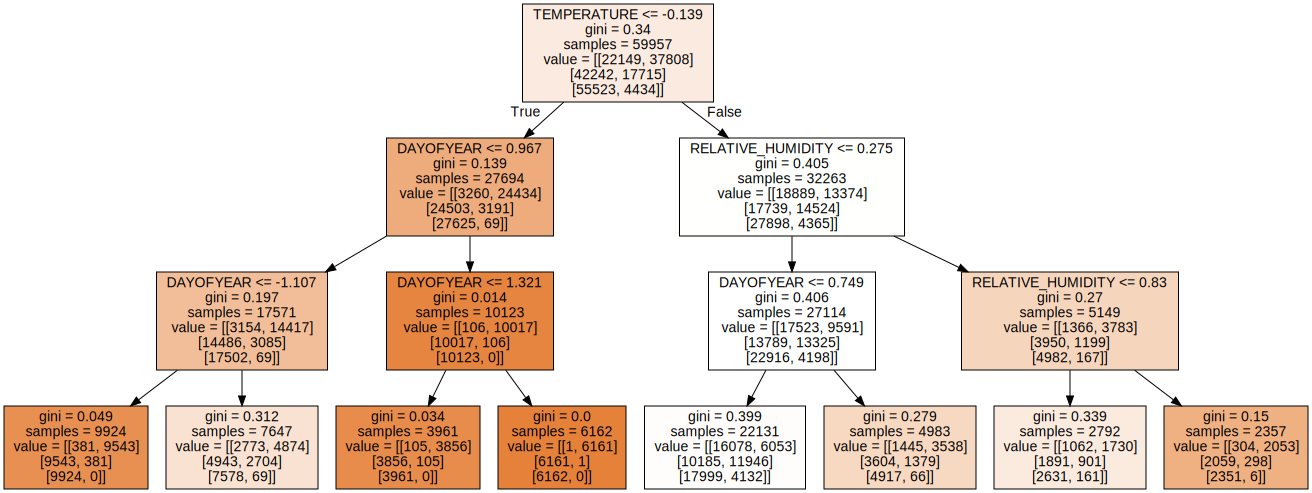

In [44]:
from sklearn.tree import export_graphviz
from graphviz import Source
tree = rf[-1]

Source(export_graphviz(tree,
                        out_file=None,
                        filled=True,
                        proportion=False,
                        leaves_parallel=False,
                        class_names=['good', 'poor', 'fair'],
                        feature_names=INPUT_VARIABLES))

Plotting feature importance reveals which features were most critical to the forest's predictions.


Variable: TEMPERATURE          Importance: 0.46
Variable: DAYOFYEAR            Importance: 0.41
Variable: RELATIVE_HUMIDITY    Importance: 0.13
Variable: WINDSPEED            Importance: 0.0



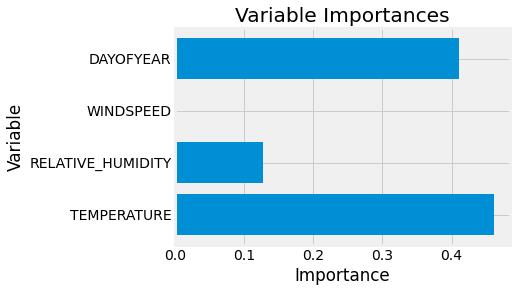

In [ ]:
def calc_importances(rf, feature_list):

    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    print('')
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    print('')

    return importances

def plot_feat_importances(importances, feature_list): 
    plt.figure()
    # Set the style
    plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances)
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')
    
    
plot_feat_importances(calc_importances(rf,  INPUT_VARIABLES),  INPUT_VARIABLES)


Permutation importance shows which features cause the largest drop in skill if they are randomly shuffled. Note that this calculation can be slow.

In [ ]:
from sklearn.inspection import permutation_importance
# Single-pass permutation
permute = permutation_importance(rf, Xval, Tval, n_repeats=20, 
                                 random_state=RAND_STATE)

# Sort the importances
sorted_idx = permute.importances_mean.argsort()

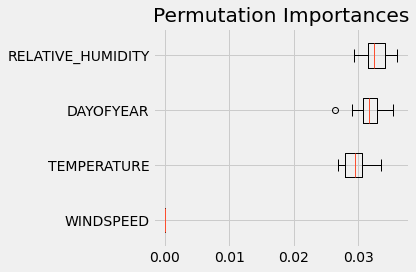

In [ ]:
def plot_perm_importances(permute, sorted_idx, feature_list):
    # Plot the permutation importances
    
    new_feature_list = []
    for index in sorted_idx:  
        new_feature_list.append(feature_list[index])

    fig, ax = plt.subplots()
    ax.boxplot(permute.importances[sorted_idx].T,
           vert=False, labels=new_feature_list)
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    
plot_perm_importances(permute, sorted_idx, INPUT_VARIABLES)

# 4. Model Testing: Do Not Run Until You've Tuned Your Model!

We have set aside some ozone data to be used for testing. Tune your model on the VALIDATION data to the best of your abilities. Once you have a model that you are confident in, run it on the testing data to see how it performs on data it has never seen before. This section uses Weighted Categorical Accuracy to measure model performance. *Once you have run the model on the testing data, you cannot continue to tune the model–it is "cheating" to tune the model to data intended to verify its performance! Once you have used the testing data, your project has finished!*

 **Enter the given CODE to run the testing data.**

In [48]:
CODE = '' # enter 'test' to run the following cells

DO NOT EDIT THE FOLLOWING:

In [49]:
def compete():

  # Read in data from url
  url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/ozone_data_joshuatreenp_" + CODE + ".csv"
  data = pd.read_csv(url,parse_dates=["DATE_TIME"],infer_datetime_format=True)

  # Fix data issue with Daylight Savings Time
  duplicate_dates = data['DATE_TIME'][data.duplicated('DATE_TIME')]
  for dup_date in duplicate_dates:
    idx = data['DATE_TIME'].eq(dup_date).idxmax()
    data.at[idx, 'DATE_TIME'] = dup_date - pd.Timedelta(value=1, unit='hours')  

  # Add hour and day of year
  data['HOUR'] = data['DATE_TIME'].dt.hour
  data['MONTH'] = data['DATE_TIME'].dt.month
  data['YEAR'] = data['DATE_TIME'].dt.year
  data['DAYOFYEAR'] = data['DATE_TIME'].dt.dayofyear
  data.sort_values('DATE_TIME', inplace=True, ignore_index = True)

  df_data_to_be_used = data[['OZONE'] + INPUT_VARIABLES] 
  df_data_to_be_used = df_data_to_be_used.rolling(8).mean()
  df_data_to_be_used[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']] = \
      data[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']] 
  df_data_to_be_used.dropna(inplace=True)

  Xcompete_raw = df_data_to_be_used[INPUT_VARIABLES].values
  output_raw = df_data_to_be_used['OZONE'].values
  hour = df_data_to_be_used['HOUR'].values
  month = df_data_to_be_used['MONTH'].values
  year = df_data_to_be_used['YEAR'].values

  output_class = (output_raw >= 55).astype(int) + (output_raw >= 71).astype(int)
  Tcompete = (output_class.reshape(-1,1) == np.unique(output_class)).astype(int)
  year_bool = lambda yrrange: np.logical_and(year>=yrrange[0], year<=yrrange[1])
  
  standardize_input = lambda dat, x, s: (dat - x)/s 
  Xcompete = standardize_input(Xcompete_raw, trainmean, trainstd)

  Pcompete = rf.predict(Xcompete)
  Cpcompete = Pcompete.argmax(axis=1)
  Ctcompete = Tcompete.argmax(axis=1)

  cat_weights = np.sum((1 / np.mean(Ttrain, axis=0)) * Tcompete, axis=1) 
  print('Congrats! Your overall weighted categorical accuracy is:', accuracy_score(Ctcompete, Cpcompete, sample_weight=cat_weights) )
  print("Predicted versus Target Classes for Competition Data")
  confusion_matrix(Cpcompete, Ctcompete)

In [50]:
compete()

HTTPError: ignored